In [26]:
from brian import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab
from sklearn.cross_validation import KFold

%matplotlib inline

Vt = -50 * mV          # spike threshold
Vr = -60 * mV          # reset value
refr_period = 5*ms # absolute refractory period

tau_e = 15*ms # membrane time constant (for excitatory synapses)
tau_i = 10*ms # membrane time constant (for inhibitory synapses)
tau_syn_2_e = 3*ms # exc synaptic time constant tau2 in paper
tau_syn_2_i = 2*ms # inh synaptic time constant tau2 in paper
tau_syn_1 = 1*ms # exc/inh synaptic time constant tau1 in paper

clear(True, True) 
reinit()# To reinit BRIAN clocks and remove all old BRIAN objects from namespace,
# it's usually a good idea to put this at the beginning of a script

eqs = Equations('''
        dV/dt  = (ge-gi-(V-mu))/taum : volt
        dge/dt = -ge/tau_syn_1       : volt
        dgi/dt = -gi/tau_syn_2       : volt
        taum : ms
        tau_syn_2 : ms
        mu : volt
        ''')

In [27]:
# Set up Neuron Groups and parameters
N_e = 4000
N_i = 1000

# bias like in the paper
mu_e = Vt + np.random.uniform(1.1, 1.2, N_e) * (Vt-Vr) # bias for excitatory neurons
mu_i = Vt + np.random.uniform(1.0, 1.05, N_i) * (Vt-Vr) # bias for excitatory neurons
# bias like in CUBA
#mu_e = -49 * mV
#mu_i = -49 * mV

# Let's create 5000 neurons
G = NeuronGroup(N=N_e+N_i,
                model=eqs,
                threshold=Vt,
                reset=Vr,
                refractory=refr_period,
                freeze = True,
                method='Euler',
                compile=True)

# Excitatory neurons, set parameters per population
Ge = G.subgroup(N_e)
Ge.taum = tau_e
Ge.tau_syn_2 = tau_syn_2_e
Ge.mu = mu_e
# Inhibitory neurons
Gi = G.subgroup(N_i)
Gi.taum = tau_i
Gi.tau_syn_2 = tau_syn_2_i
Gi.mu = mu_i

In [28]:
def determine_cluster_probs(Ree, its = 1000): 
    '''
    greedy algorithm for determining p_in and p_out from R_ee and 0.2 = 0.5*(p_in + p_out)
    '''
    # initial values
    p_in = 0.2
    p_out = 0.2
    # counter
    i=0
    # while the ration Ree is not reached, increase p_in slightly and adapt p_out 
    while not(np.round(p_in/p_out,1)==Ree): 
        p_in += 0.001
        # from constraint: mean = 0.2
        p_out = 0.4 - p_in 
        i += 1
        if i>1000: 
            raise Warning("Too many iterations, change values")
            break
    return p_in, p_out

In [29]:
# Set up connections
# Connection probability, on average
conn_prob_ee = 0.2
conn_prob_ii = 0.5
conn_prob_ei = 0.5
conn_prob_ie = 0.5

# Cluster coefficient 
R_ee = 2.5
# connection probs for clusters
p_in, p_out = determine_cluster_probs(R_ee)

# use absolute weights because inhibitory influence is given by sign of y above
wee = 0.024 *mV
wei = 0.045 *mV
wii = 0.057 *mV
wie = 0.014 *mV
# for clusters 
wee_out = wee
wee_in = 1.9 * wee_out # stronger connections within clusters

In [30]:
# set up connections

# if cluster exist, set connections for every cluster
if not(R_ee==1.0):
    # set up connections in clusters: 
    # make partition of 50 clusters of 80 neurons each
    kf = KFold(n=4000, n_folds=50)
    for idx_out, idx_in in kf: # idx_out holds all other neurons; idx_in holds all cluster neurons
        # set up cluster groups 
        # in cluster
        neurons_in = Ge[idx_in[0]:idx_in[-1]]
        # out cluster
        neurons_out = Ge[idx_out[0]:idx_out[-1]]
        # set up connections
        # within cluster
        cluster_conns_ii = Connection(neurons_in, neurons_in, 'ge', sparseness=p_in, weight=wee_in)
        # out of cluster
        cluster_conns_io = Connection(neurons_in, neurons_out, 'ge', sparseness=p_out, weight=wee_out)
else: # else set all connections equal
        Cee = Connection(neurons_e, neurons_e, 'ge', sparseness=conn_prob_ee, weight=wee)

# clusters are only set up for excitatory neurons --> we need to set up the connections to inhibitory neurons
Cei = Connection(Ge, Gi, 'ge', sparseness=conn_prob_ei, weight=wei)
Cie = Connection(Gi, Ge, 'gi', sparseness=conn_prob_ie, weight=wie)
Cii = Connection(Gi, Gi, 'gi', sparseness=conn_prob_ii, weight=wii)

In [31]:
M = SpikeMonitor(G)
# neuron to monitor
neuron_idx = 0
MV = StateMonitor(G, 'V', record=neuron_idx)
Mge = StateMonitor(G, 'ge', record=neuron_idx)
Mgi = StateMonitor(G, 'gi', record=neuron_idx)

In [32]:
G.V = Vr + (Vt - Vr) * rand(len(G))
run(500 * ms)

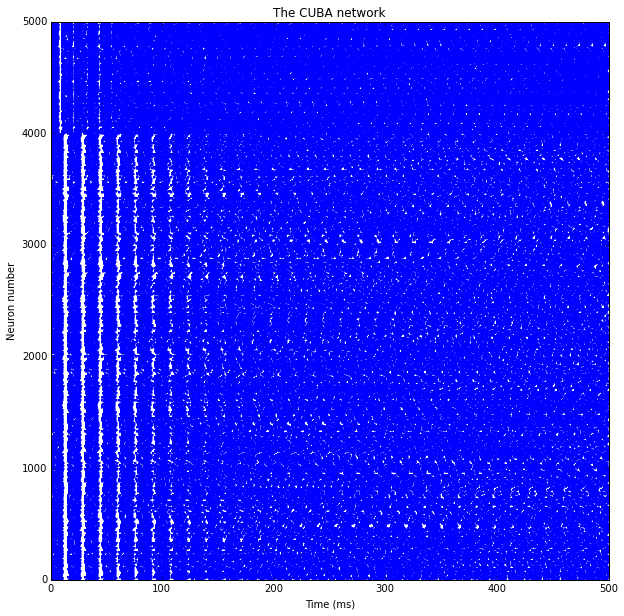

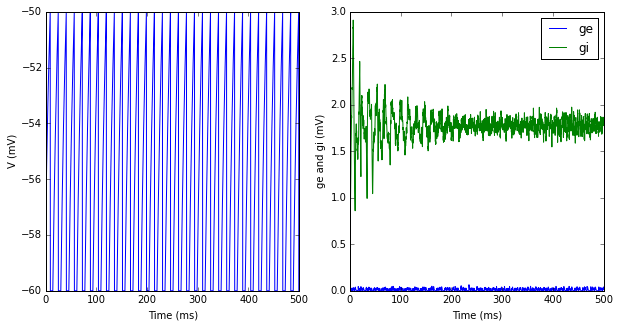

In [33]:
plt.figure(figsize=(10,10))
raster_plot(M, title='The CUBA network', newfigure=False)
plt.figure(figsize=(10,5))
plt.subplot(121)
plot(MV.times / ms, MV[neuron_idx] / mV)
xlabel('Time (ms)')
ylabel('V (mV)')
subplot(122)
plot(Mge.times / ms, Mge[neuron_idx] / mV)
plot(Mgi.times / ms, Mgi[neuron_idx] / mV)
xlabel('Time (ms)')
ylabel('ge and gi (mV)')
legend(('ge', 'gi'), 'upper right')
show()